# BART fine-tuning

1. BART-WikiLarge
2. BART-SWIPE
3. BART-SWIPE-C



> The best checkpoint based on validation F-1 was selected, achieving a validation F-1 score of 77.5.

- Time: 1 hour
- GPU: a single A100 GPU
- runs : 50 (per iteration)

In [2]:
!nvidia-smi

Thu Sep 12 08:57:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100                    On  | 00000000:84:00.0 Off |                    0 |
| N/A   24C    P0              68W / 699W |      8MiB / 95830MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Load dataset

Data:

- swipe_train.json
- swipe_val.json
- swipe_test_id.json -> in-domain test set
- swipe_test_ood.json -> out of domain test set

# Load BART-large Model 

BART https://huggingface.co/docs/transformers/v4.44.2/en/model_doc/bart

bart-large -> bart-base

In [3]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', use_fast=True)
model =  BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

## BART config

In [2]:
from transformers import BartConfig

config = BartConfig.from_pretrained('facebook/bart-large')
print("Before modification:", config.architectures)

Before modification: ['BartModel']


/home/acg16943ws/miniforge/envs/nlp/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# modify the architectures field
config.architectures = ["BartForConditionalGeneration"]
#config.torch_dtype = 'bfloat16' # original: "float32"
#config.decoder_start_token_id = 2
config.decoder_start_token_id = config.bos_token_id 
config.bos_token_id = 0
config.eos_token_id = 2

config.decoder_start_token_id = 2
config.pad_token_id =1
print("After modification:", config.architectures)
print("After modification:", config.decoder_start_token_id)

After modification: ['BartForConditionalGeneration']
After modification: 2


In [4]:
model = BartForConditionalGeneration(config)

# Compare models

In [17]:
def get_memory_usage(model_name):
    torch.cuda.empty_cache() 
    model = BartForConditionalGeneration.from_pretrained(model_name).cuda()
    memory_allocated = torch.cuda.memory_allocated()
    del model
    torch.cuda.empty_cache()
    return memory_allocated

bart_large_memory = get_memory_usage("facebook/bart-large")
print(f"Memory used by bart-large: {bart_large_memory / 1024 ** 2:.2f} MB")

bart_base_memory = get_memory_usage("facebook/bart-base")
print(f"Memory used by bart-base: {bart_base_memory / 1024 ** 2:.2f} MB")

Memory used by bart-large: 1550.07 MB
Memory used by bart-base: 532.78 MB


In [7]:
# number of trainable parameters
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_parameters}")

Total number of trainable parameters: 406291456


# Tokenize the datasets

In [9]:
def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['r_content'], truncation=True, padding="max_length", max_length=512)
    # labels
    labels = tokenizer(examples['s_content'], truncation=True, padding="max_length", max_length=512)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids']
    return inputs

tokenized_datasets = swipe_dataset.map(tokenize_func, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/3847 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

Map:   0%|          | 0/483 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets.save_to_disk("../data/tokenized_swipe_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/3847 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/479 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/483 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/368 [00:00<?, ? examples/s]

# Train the model

Category Classification Models:

- batch-size: 6
- apex: half-precision
- epochs: 7
- learning rate: 10^−5

In [4]:
from datasets import load_from_disk

tokenized_datasets = load_from_disk("../data/tokenized_swipe_dataset")

In [5]:
print(len(tokenized_datasets['train']['input_ids']))
print(len(tokenized_datasets['train']['labels']))

3847
3847


## Check memory usage

In [14]:
!du -sh ../main/*

36K	../main/BART_finetuning.ipynb
108K	../main/BART-SWiPE.ipynb
12K	../main/datasets.ipynb
8.0K	../main/ragsimp.ipynb
2.0M	../main/swipe-clean.ipynb


In [15]:
!du -sh ../data/*

536K	../data/bert_scores_test_id.csv
1.6M	../data/bert_scores_test_ood.csv
4.7M	../data/bert_scores_train.csv
604K	../data/bert_scores_val.csv
4.0K	../data/folder_download.ipynb
45M	../data/swipe_clean
8.8M	../data/swipe_generator_data.json
2.2M	../data/swipe_test_id.json
4.4M	../data/swipe_test_ood.json
18M	../data/swipe_train.json
2.3M	../data/swipe_val.json
528K	../data/test_id_df_cleaned.csv
580K	../data/test_ood_df_cleaned.csv
39M	../data/tokenized_swipe_dataset
4.0M	../data/train_df_cleaned.csv
512K	../data/val_df_cleaned.csv


In [3]:
!nvidia-smi

Fri Sep  6 09:43:33 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3D:00.0 Off |                    0 |
| N/A   43C    P0    62W / 300W |    579MiB / 16384MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   

In [4]:
import torch

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_in_use = torch.cuda.memory_allocated(0)
    gpu_memory_free = torch.cuda.memory_reserved(0)
    
    print(f"Total GPU Memory: {gpu_memory / 1e9:.2f} GB")
    print(f"Memory in Use: {gpu_memory_in_use / 1e9:.2f} GB")
    print(f"Free Memory: {gpu_memory_free / 1e9:.2f} GB")
else:
    print("CUDA is not available")

Total GPU Memory: 16.94 GB
Memory in Use: 0.21 GB
Free Memory: 0.22 GB


In [5]:
torch.cuda.empty_cache()

# Training

In [6]:
print(tokenizer.pad_token)
print(tokenizer.eos_token)

<pad>
</s>


In [7]:
from datasets import load_metric

sari_metric = load_metric("sari")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # list of references per sentence
    decoded_labels = [[label] for label in decoded_labels]
    sari_score = sari_metric.compute(predictions=decoded_preds, sources=decoded_labels, references=decoded_labels)

    return {
        "sari": sari_score["sari"],
    }

/tmp/1042984.1.all.q/ipykernel_489864/1741379274.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  sari_metric = load_metric("sari")


The repository for sari contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sari.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [13]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.integrations import TensorBoardCallback

training_args = TrainingArguments(
    output_dir="../models/bart-swipe/results",
    eval_strategy="epoch", 
    save_strategy = "epoch", 
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5, 
    per_device_train_batch_size=6, # 6 -> 4 2 
    per_device_eval_batch_size=6, # 6 -> 4 2
    num_train_epochs=3, # 3 -> 10 -> 20
    weight_decay=0.01,
    save_total_limit=4, # 3
    #gradient_accumulation_steps=6, # reduce memory
    load_best_model_at_end=True, # based on valid loss
    warmup_steps = 2,
    optim = "paged_adamw_8bit", # optimizer for quantization
    fp16=True, # enable half-precision
    logging_dir='../models/bart-swipe/logs'
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    callbacks=[TensorBoardCallback(), EarlyStoppingCallback(early_stopping_patience=3)]
    #compute_metrics=compute_metrics,
    #data_collator=data_collator
)

# silence warnings
model.config.use_cache = False

You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


In [12]:
trainer.evaluate()

{'eval_loss': 18.412118911743164,
 'eval_runtime': 3.281,
 'eval_samples_per_second': 145.993,
 'eval_steps_per_second': 24.383}

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.183400,0.182223
2,0.276000,0.178609
3,0.130400,0.176042


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=1926, training_loss=0.6327070244128583, metrics={'train_runtime': 220.1152, 'train_samples_per_second': 52.432, 'train_steps_per_second': 8.75, 'total_flos': 1.2505277106487296e+16, 'train_loss': 0.6327070244128583, 'epoch': 3.0})

# Visualize training process

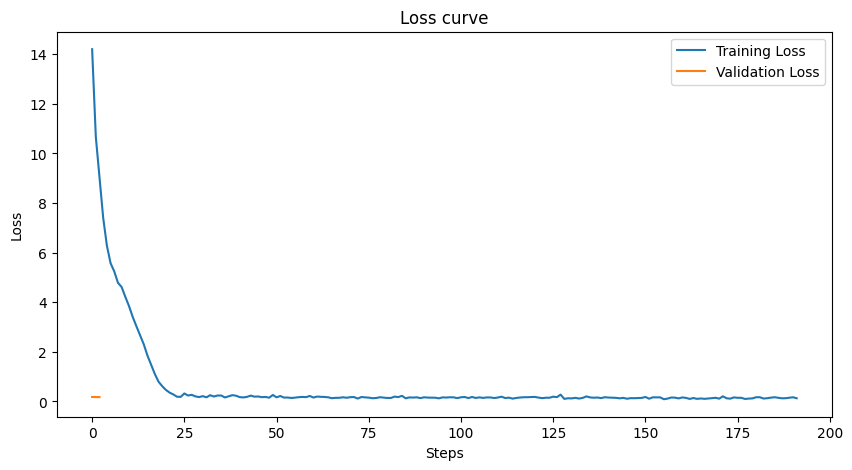

In [17]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

In [18]:
# reenable the warnings
model.config.use_cache = True

In [19]:
import torch

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_in_use = torch.cuda.memory_allocated(0)
    gpu_memory_free = torch.cuda.memory_reserved(0)
    
    print(f"Total GPU Memory: {gpu_memory / 1e9:.2f} GB")
    print(f"Memory in Use: {gpu_memory_in_use / 1e9:.2f} GB")
    print(f"Free Memory: {gpu_memory_free / 1e9:.2f} GB")
else:
    print("CUDA is not available")

Total GPU Memory: 99.87 GB
Memory in Use: 1.70 GB
Free Memory: 10.10 GB


# Load model from checkpoint

In [ ]:
import os

def find_latest_checkpoint(checkpoint_dir):
    # all subdirectories in the checkpoint directory
    checkpoints = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if os.path.isdir(os.path.join(checkpoint_dir, d))]
    # checkpoints by directories containing the word 'checkpoint'
    checkpoints = [d for d in checkpoints if 'checkpoint' in d]
    # sort checkpoints by modification time (latest first)
    checkpoints.sort(key=os.path.getmtime, reverse=True)
    if checkpoints:
        return checkpoints[0]
    else:
        print("No checkpoints found.")
        return None

latest_checkpoint = find_latest_checkpoint("../models/bart-swipe/results")
print(f"Latest checkpoint: {latest_checkpoint}")

# Generate predictions

In [20]:
import difflib
from IPython.display import display, HTML

def highlight_diff(sentence1, sentence2):
    diff = difflib.ndiff(sentence1, sentence2)
    highlighted = []
    
    for char in diff:
        if char.startswith('-'):
            highlighted.append(f"<span style='color:red'>{char[2:]}</span>")
        elif char.startswith('+'):
            highlighted.append(f"<span style='color:green'>{char[2:]}</span>")
        else:
            highlighted.append(char[2:])
    
    return ''.join(highlighted)

In [21]:
from datasets import load_from_disk
import pandas as pd

# load-in a cleaned dataset
swipe_dataset = load_from_disk("../data/swipe_clean")

In [22]:
print(f"decoder_start_token_id: {model.config.decoder_start_token_id}")
print(f"bos_token_id: {model.config.bos_token_id}")

decoder_start_token_id: 2
bos_token_id: 0


In [27]:
example = swipe_dataset['test_id'][1]  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

output_ids = model.generate(
    **inputs, 
    #max_new_tokens = 50,
    max_length=512, 
    min_length=50, 
    length_penalty=1.0, 
    num_beams=4, 
    #no_repeat_ngram_size=2,
    early_stopping=True
)
simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Original: {example['r_content']}", end='\n\n')
print(f"Simplified: ")
print(simplified_text, end='\n\n')
print(f"Simplified (highlighted): ")
display(HTML(highlight_diff(example['r_content'],simplified_text)))

Original: Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the former Soviet Union, and was also widely taught in schools in member countries of the Warsaw Pact. In Soviet times, Russian was often strongly promoted to the detriment of other local languages. While many of the countries of the former Soviet Union are now promoting their local languages rather than Russian, Russian remains widely spoken in these areas and is often used for intercommunication between these countries. Russian is one of the official languages of the United Nations. Russian is written using the Cyrillic alphabet. Russenorsk is a pidgin language combining Russian and Norwegian. See also: Common phrases in different languages See also: Languages of China --

Simplified: 
Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the for

# Evaluation

In [36]:
from tqdm import tqdm

predictions = []
references = []  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for example in tqdm(swipe_dataset['test_id']):
    # tokenize the text
    input_ids = tokenizer(example['r_content'], return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    # move input_ids to the same device as the model
    input_ids = {key: value.to(device) for key, value in input_ids.items()}
    
    # generate prediction
    output_ids = model.generate(**input_ids,max_length = 512, min_length=50, length_penalty=1.0, num_beams=4, early_stopping=True) #max_length=200, min_length=50,
    simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    predictions.append(simplified_text)
    references.append(example['s_content'])

100%|███████████████████████████████████████████| 483/483 [08:33<00:00,  1.06s/it]


In [37]:
df_results = pd.DataFrame({
    'text': swipe_dataset['test_id']['r_content'],
    'reference': swipe_dataset['test_id']['s_content'],
    'prediction': predictions
})

df_results.to_csv("../data/predictions_bart-large-swipe.csv", index=False)
df_results.head()

,text,reference,prediction
0,The term jargon may have the following meaning...,Jargon is a special way to use words that are ...,The term jargon may have the following meaning...
1,"Russian (Russkij yazyk, Русский язык) is the m...",Russian (русский язык (russkij yazyk)) is the ...,"Russian (Russkij yazyk, Русский язык) is the m..."
2,"Great Britain, also called Britain, is an isla...",Great Britain is the main part of the United K...,"Great Britain, also called Britain, is an isla..."
3,"Transport, or transportation (as it is called ...",Transport is the movement of people and things...,"Transport, or transportation (as it is called ..."
4,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...,Stockholm is the capital of Sweden. It is loca...,Stockholm (help·info) (IPA: ['stɔkhɔlm]; UN/LO...


## SARI score

- paper: 47

- fine-tuned : 48

In [38]:
from datasets import load_metric
import pandas as pd

sari_metric = load_metric("sari")
sari_scores = []

for index, row in tqdm(df_results.iterrows(), total=len(df_results)):
    r_content = row['text'] 
    s_content = row['reference']  
    prediction = row['prediction']  
    
    sari_score = sari_metric.compute(
        sources=[r_content],
        predictions=[prediction],
        references=[[s_content]] 
    )
    
    sari_scores.append(sari_score['sari'])

100%|██████████████████████████████████████████| 483/483 [00:03<00:00, 135.40it/s]


In [45]:
df = pd.DataFrame({
    'text': swipe_dataset['test_id']['r_content'],
    'reference': swipe_dataset['test_id']['s_content'],
    'prediction': predictions,
    'sari_score': sari_scores
})

df.to_csv("../data/bart-large-swipe_sari.csv", index=False)

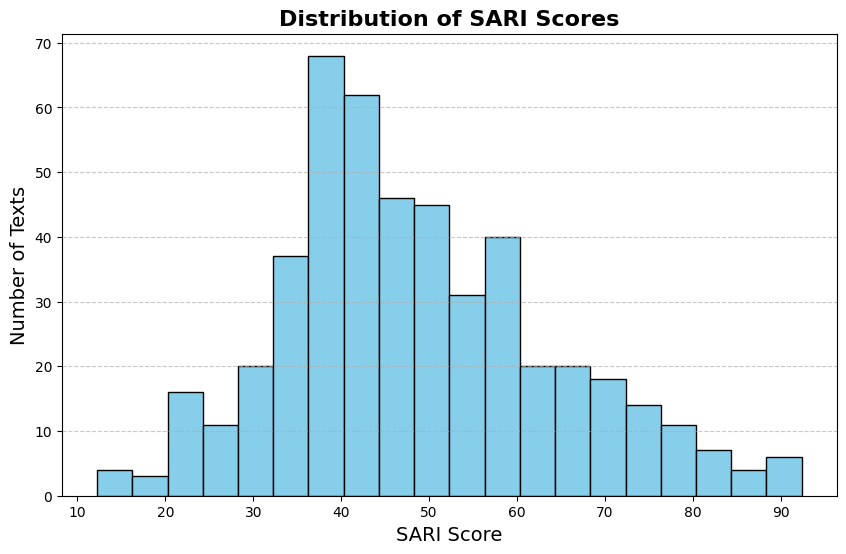

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sari_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of SARI Scores', fontsize=16, fontweight='bold')
plt.xlabel('SARI Score', fontsize=14)
plt.ylabel('Number of Texts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [40]:
import numpy as np

print("Overall SARI score: ", np.mean(sari_scores))

Overall SARI score:  48.66193435869


# Inspect results

In [41]:
references[1]

'Russian (русский язык (russkij yazyk)) is the most widely spoken of the Slavic languages. Russian is the official language of Russia, and an official language of Belorussia, Kazakhstan and Kyrgyzstan. Russian is one of the five official languages of the United Nations. People were encouraged to speak Russian in the former Soviet Union, but now, many countries that were once part of the Soviet Union speak a local language.'

In [42]:
predictions[1]

'Russian (Russkij yazyk, Русский язык) is the most widely spoken of the Slavic languages. It is primarily spoken in Russia and other nations of the former Soviet Union, and was also widely taught in schools in member countries of the Warsaw Pact. In Soviet times, Russian was often strongly promoted to the detriment of other local languages. While many of the countries of Russia and the former USSR are now promoting their local languages rather than Russian, Russian remains widely spoken in these areas and is often used for intercommunication between these countries. Russian is one of the official languages of the United Nations. Russenorsk is a pidgin language combining Russian and Norwegian.'

## Low SARI scores

Texts almost without simplification, where a huge part of original text was deleted.

Main traits: very long texts (over 512 characters)

In [47]:
df_to_check = df[df['sari_score']<20]
print('Num of records: ', len(df_to_check))

Num of records:  7


In [53]:
for idx, row in df_to_check.iterrows():
    print("ID: ", idx)
    print("Text: ")
    print(row['text'], end='\n\n')
    print("Reference:")
    print(row['reference'], end='\n\n')
    print("Simplification: ")
    print(row['prediction'], end='\n\n')
    display(HTML(highlight_diff(row['text'],row['prediction'])))
    print('\n\n')

ID:  51
Text: 
Masoud Barzani (Kurdish: مەسعوود بارزانی or Mesûd Barzanî; born 16 August 1946) is a Kurdish politician who has been President of the Iraqi Kurdistan Region since 2005. However, Barzani’s post has sparked controversy, as his tenure expired 19 August 2015. He is also leader of the Kurdistan Democratic Party (KDP) since 1979. Masoud Barzani succeeded his father, the Kurdish nationalist leader Mustafa Barzani, as the leader of the KDP in 1979. Working closely with his brother Idris Barzani until Idris's death, Barzani and various other Kurdish groups fought the forces of the Iraqi government in Baghdad during the Iran–Iraq War. For much of this time, the Kurdish leadership was exiled to Iran. Barzani was born in Iranian Kurdistan, during the short-lived Republic of Mahabad.

Reference:
Massoud Barzani (born 16 August 1946) was the first president of Iraqi Kurdistan. He became President on 14 June 2005. Masoud Barzani succeeded his father, the Kurdish nationalist leader Must




ID:  148
Text: 
South Sudan, officially the Republic of South Sudan, is a country in East Africa. Its capital and largest city is Juba, located in the southern state of Central Equatoria. The landlocked country is bordered by Ethiopia to the east; Kenya to the southeast; Uganda to the south; the Democratic Republic of the Congo to the southwest; and the Central African Republic to the west; and the Republic of Sudan to the north. South Sudan includes the vast swamp region of the Sudd formed by the White Nile, locally called the Bahr al Jabal. What is now South Sudan was initially part of the British and Egyptian condominium of Anglo-Egyptian Sudan and became part of the Republic of Sudan when independence was achieved in 1956. Following the First Sudanese Civil War, the Southern Sudan Autonomous Region was formed in 1972 and lasted until 1983. A second Sudanese civil war soon developed and ended with the Comprehensive Peace Agreement of 2005. Later that year, southern autonomy was r




ID:  197
Text: 
The Papahānaumokuākea Marine National Monument (or often Northwestern Hawaiian Islands Marine National Monument) is a World Heritage listed, U.S. National Monument encompassing 140,000 square miles (360,000 km2) (an area larger than the country of Greece) of ocean waters, including ten islands and atolls of the Northwestern Hawaiian Islands, internationally recognized for both its cultural and natural values as follows:

Reference:
The Papahānaumokuākea Marine National Monument is a World Heritage site. It is often called Northwestern Hawaiian Islands Marine National Monument. The site covers 140,000 square miles (360,000 km2) of ocean waters that includes ten islands and atolls. The size is larger than the country of Greece. The area was made a national monument by U.S. President George W. Bush on June 15, 2006. It became a World Heritage site on July 30, 2010. Papahānaumokuākea supports 7,000 species. One quarter of the species are endemic.

Simplification: 
The Pa




ID:  234
Text: 
Seleucus I Nicator[A] (c. 358 BC – 281 BC) (Ancient Greek: Σέλευκος Α΄ Νικάτωρ) was one of the Diadochi.[B] Having previously served as an infantry general under Alexander the Great, he eventually assumed the title of basileus[C] and established the Seleucid Empire over much of the territory in the Near East which Alexander had conquered. After the death of Alexander in June 323 BC, Seleucus initially supported Perdiccas, the regent of Alexander's empire, and was appointed Commander of the Companions and chiliarch at the Partition of Babylon in 323 BC. However, after the outbreak of the Wars of the Diadochi in 322, Perdiccas' military failures against Ptolemy in Egypt led to the mutiny of his troops in Pelusium. Perdiccas was betrayed and assassinated in a conspiracy by Seleucus, Peithon and Antigenes in Pelusium sometime in either 321 or 320 BC. At the Partition of Triparadisus in 321 BC, Seleucus was appointed Satrap of Babylon under the new regent Antipater. But a




ID:  258
Text: 
Grossaffoltern is a municipality in the Seeland administrative district in the canton of Bern in Switzerland. It is known for its stork colony.

Reference:
Grossaffoltern is a municipality in the administrative district of Seeland in the canton of Bern in Switzerland.

Simplification: 
Grossaffoltern is a municipality of the Seeland administrative district in the canton of Berne in Switzerland. It is known for its stork colony. The municipality has a population of 2,908 (1999). The municipality was founded in 1869.






ID:  262
Text: 
A scripting or script language is a programming language that supports scripts, programs written for a special run-time environment that automate the execution of tasks that could alternatively be executed one-by-one by a human operator. Scripting languages are often interporeted (rather than compiled). Primitives are usually the elementary tasks or API calls, and the language allows them to be combined into more complex programs. Environments that can be automated through scripting include software applications, web pages within a web browser, the shells of operating systems (OS), embedded systems, as well as numerous games. A scripting language can be viewed as a domain-specific language for a particular environment; in the case of scripting an application, this is also known as an extension language. Scripting languages are also sometimes referred to as very high-level programming languages, as they operate at a high level of abstraction, or as control languages, 




ID:  283
Text: 
Afridun Amu is the first Afghan athlete to internationally represent Afghanistan in surfing. He participated in the International Surfing Association World Surfing Games in Biarritz, France in May 2017. Amu also won the first official Afghan surfing championship (man) in 2015 in Ericeira, Portugal. He is the reigning Afghan surf champion.[when?] Amu was born in Kabul, Afghanistan on June 23, 1987. He spent his childhood in Moscow, Russia, where his father worked as a diplomat. His family moved to Germany as political refugees in 1992. He graduated in law, cultural science and design thinking. He works as an expert in Constitutional law at the Max Planck Foundation for International Peace and the Rule of Law and is a lecturer on Design thinking at the Hasso Plattner Institute.

Reference:
Afridun Amu was the first Afghan athlete to internationally represent Afghanistan in surfing. He participated in the International Surfing Association World Surfing Games in Biarritz

## Medium SARI scores

Main operations: copy, delete and minimal insertion

Main traits: medium-length texts

In [61]:
df_to_check = df[(df['sari_score']>48) & (df['sari_score']<49)]
print('Num of records: ', len(df_to_check))

Num of records:  10


In [62]:
for idx, row in df_to_check.iterrows():
    print("ID: ", idx)
    print("Text: ")
    print(row['text'], end='\n\n')
    print("Reference:")
    print(row['reference'], end='\n\n')
    print("Simplification: ")
    print(row['prediction'], end='\n\n')
    display(HTML(highlight_diff(row['text'],row['prediction'])))
    print('\n\n')

ID:  134
Text: 
Gravity is the title of Canadian alternative rock band Our Lady Peace's fifth studio album. It was released on June 18, 2002 by Columbia Records in North America. The album became a worldwide success, charting highly both in Canada and the U.S. with the hit singles "Somewhere Out There" and "Innocent". The album title, Gravity, was inspired by the chorus lyrics "Falling back to me, defying gravity" from the track "Somewhere Out There". At the time of the album's release, OLP drummer Jeremy Taggart said that Gravity was "by far [their] best album". This was their first album to feature new guitarist, Steve Mazur, who replaced Mike Turner after the latter's departure in December 2001. Turner is on some of the albums tracks, however, having recorded parts for several songs on the album prior to his departure. This was also their last album with stunt musician Jamie Edwards, who left the band soon after the album was completed.

Reference:
Gravity is the fifth studio album 




ID:  214
Text: 
Robert Thomas Mason (born April 22, 1961 in International Falls, Minnesota) is a retired American ice hockey goaltender. A member of the 1984 U.S. Olympic Hockey Team, Mason's professional career began when he was signed as a free agent by the Washington Capitals. He had two stints with the Capitals (1984–87 and 1989–90). During his first stint, he was involved in one of the longest playoff games in NHL history against the New York Islanders in 1987, which took four overtimes to decide the outcome. Mason also played for the Chicago Blackhawks (1987–88), Quebec Nordiques (1988–89), and Vancouver Canucks (1990–91). Today, Mason is the goaltending coach for the Minnesota Wild. Previously, he was the goaltending coach for the Atlanta Thrashers during the first two years of the franchise's existence.

Reference:
Robert Thomas Mason (born April 22, 1961) is an American retired professional ice hockey goaltender and current goaltending coach for the Minnesota Wild. Mason pl




ID:  248
Text: 
The Roland Alpha Juno series of keyboards are analog polyphonic synthesizers with a digitally controlled oscillator manufactured by Roland Corporation in 1985 to 1986. Two models were released: the Alpha Juno 1 (JU-1) (1985-1986), and the Alpha Juno 2 (JU-2) (1985-1986), which added one octave of notes, a cartridge slot and touch-sensitivity. Alpha Juno synthesizers were notable for their reduced user interface compared to other synths of the day, with a single Alpha Dial replacing many sliders and knobs. The keyboard features MIDI in, out and thru, mono, stereo and headphone sockets. It also supports an external footpedal controller, and tape backup. The MKS-50 (1986) is a rack-mount version of the Alpha Juno. It has the same synth engine and architecture, with some added features like 16 programmable chord memories, the ability to store velocity, volume, panning, de-tune, portamento and other similar parameters within each patch you create. The Alpha Juno is notabl




ID:  280
Text: 
There have been 50 total women in the United States Senate since its establishment in 1789. The first woman senator, Rebecca Felton, served in 1922 (for a single day), but the first woman elected to the Senate was Hattie Caraway in 1932. Fourteen of the women who have served were appointed; seven of those were appointed to succeed their deceased husbands. Currently (as of 2017), the 115th Congress has 21 female senators out of 100 (21%), one more than both the 113th and 114th congresses, and an all-time high.

Reference:
There have been 50 women in the United States Senate since it started in 1789. Rebecca Felton was the first. She was in the Senate for one day in 1922. Hattie Caraway was the first woman elected to the Senate in 1932. Fourteen of the women Senators were not elected. They were appointed. Seven of them were appointed to replace their dead husbands. In 2017 there are 21 female senators out of 100. That is the largest number of women in the Senate at the




ID:  289
Text: 
Barbara Knox MBE (born 30 September 1933), is a British actress, known for her portrayal of newsagent Rita Tanner in the television soap opera Coronation Street. She has been a full-time cast member for over 45 years, having appeared for one episode as Rita in 1964, before becoming a regular cast member from 1972 onwards. Knox made her professional stage debut in 1962 at the Oldham Coliseum Theatre, had a small role as a dancer in the 1969 remake of Goodbye Mr. Chips and appeared opposite Ken Dodd in his 1972 comedy series Funny You Should Say That. She won the 1989 TV Times Award for Best Actress for one of her best remembered storylines, involving the Alan Bradley character. In 2006, she won the British Soap Award for Best On-Screen Partnership with Malcolm Hebden, having previously received the Lifetime Achievement Award at the 2004 ceremony. She was made an MBE in the 2010 Queen's Birthday Honours.

Reference:
Barbara Knox MBE (born 30 September 1933), is a Briti




ID:  342
Text: 
Protopresbyter (Archpriest) Fr. George Metallinos (in Greek π. Γεώργιος Μεταλληνός) (11 March 1940 – 19 December 2019) was a Greek theologian, priest, historian, author and professor. He was born in Corfu, Greece on 11 March 1940, where he also completed his Secondary Education. He was a graduate of the University of Athens in Theology (1962) and Classical Literature (1967). After his military service (1963–1965) he became Research Assistant at the Department of Patrology and in 1969 he went to Western Germany for post graduate studies in Bonn and Cologne, where he resided until 1975. During this time he also conducted studies and archival research in England. In 1971, he was ordained a member of the clergy and became Doctor of Theology (University of Athens) and Doctor of Philosophy - History (University of Cologne). In 1984 he became Professor at the School of Theology of the University of Athens, teaching History of Spirituality during the Post-Byzantine Period, H




ID:  357
Text: 
Ismailia Governorate (Arabic: محافظة الإسماعيلية Muḥāfāzah Al Ismāʿīliya, IPA: [moˈħɑfzˤet elʔesmæʕeˈlejjæ]) is one of the Canal Zone governorates of Egypt. Located in the northeastern part of the country, its capital is the city of Ismailia. It was named after Ismail Pasha, who as Ottoman Viceroy of Egypt, oversaw the country during the building of the Suez Canal. It is located between the other two Canal governorates; Port Said Governorate, in the Northern part of Egypt and Suez Governorate.

Reference:
Ismailia Governorate is a governorate in Egypt. The capital city is also named Ismailia. It was named after Ismail Pasha, who as Ottoman Viceroy of Egypt, oversaw the country during the building of the Suez Canal.

Simplification: 
Ismailia Governorate (Arabic: محافظة الإسماعيلية Muḥāfāzah Al Ismāʿīliya, IPA: [moˈħɑfzˤet elʔesmæʕeˈlejjæ]) is one of the Canal Zone governorates of Egypt. Located in the northeastern part of the country, its capital is the city of Ismai




ID:  414
Text: 
The Star is a 2017 American computer-animated Christian comedy film directed by Timothy Reckart. Inspired by the Nativity of Jesus, the film's screenplay was written by Carlos Kotkin and Simon Moore, based on an original idea by Tom Sheridan. It is produced by Sony Pictures Animation, with partnership from Walden Media, Affirm Films and The Jim Henson Company. It stars the voices of Steven Yeun, Gina Rodriguez, Zachary Levi, Keegan-Michael Key, Kelly Clarkson, Patricia Heaton, Kristin Chenoweth, Tracy Morgan, Tyler Perry, and Oprah Winfrey. The film was released by Columbia Pictures through its parental label Sony Pictures Entertainment on November 17, 2017 in the United States. The film received mixed reviews from critics and grossed $62 million worldwide. It received a nomination for Best Original Song ("The Star" by Mariah Carey) at the 75th Golden Globe Awards but lost to "This Is Me". A sequel, The Star 2: Vore T, was released on March 1, 2021.

Reference:
The S




ID:  476
Text: 
Bernard Pons (born 18 July 1926, Beziers) was a French politician and medical doctor who was a member of the Union of Democrats for the Republic from 1971 to 1976 and a member of the Rally for the Republic party thereafter. He has served as Secretary General of Rally for the Republic, Minister for Transport and continued as a special advisor to the Union for a Popular Movement until 2008 after his retirement from active politics in 2002.

Reference:
Bernard Pons (18 July 1926 – 27 April 2022) was a French politician and medical doctor. He was a member of the Union of Democrats for the Republic from 1971 to 1976 and a member of the Rally for the Republic party after. He was the Minister for Transport from 1995 until 1997. He was an advisor for the Union for a Popular Movement until 2008 after his retirement from active politics in 2002. Pons was also a member of the National Assembly from 1997 until 2002. Pons was born in Béziers, France. Pons died on 27 April 2022 in




ID:  481
Text: 
hkljg Count von Count (known simply as the Count) is a mysterious but friendly vampire Muppet on the long-running PBS/HBO children's television show Sesame Street who is meant to parody Bela Lugosi's portrayal of Count Dracula. He first appeared on the show in the Season 4 premiere in 1972, counting blocks in a sketch with Bert and Ernie.

Reference:
Count von Count (known simply as the Count) is a mysterious but friendly vampire Muppet on the long-running PBS/HBO children's television showSesame Street who is meant to parody Bela Lugosi's portrayal of Count Dracula. He first appeared on the show in the Season 4 premiere in 1972, counting blocks in a sketch with Bert and Ernie.

Simplification: 
Count von Count (known simply as the Count) is a mysterious but friendly vampire Muppet on the long-running PBS/HBO children's television show Sesame Street. He is meant to parody Bela Lugosi's portrayal of Count Dracula. He first appeared on the show in the Season 4 premiere

## High SARI scores

Main operations: insertion, copy, deletion

Main traits: very short texts

In [63]:
df_to_check = df[df['sari_score']>90]
print('Num of records: ', len(df_to_check))

Num of records:  5


In [64]:
for idx, row in df_to_check.iterrows():
    print("ID: ", idx)
    print("Text: ")
    print(row['text'], end='\n\n')
    print("Reference:")
    print(row['reference'], end='\n\n')
    print("Simplification: ")
    print(row['prediction'], end='\n\n')
    display(HTML(highlight_diff(row['text'],row['prediction'])))
    print('\n\n')

ID:  87
Text: 
Boëssé-le-Sec is a commune in the Sarthe department in the region of Pays-de-la-Loire in northwestern France.

Reference:
Boëssé-le-Sec is a commune. It is found in the region Pays de la Loire in the Sarthe department in the west of France.

Simplification: 
Boëssé-le-Sec is a commune. It is found in the region Pays de la Loire in the Sarthe department in the west of France. In 2018, 1,819 people lived there.






ID:  99
Text: 
Asnières-en-Bessin is a commune in the Calvados department in the Basse-Normandie region in northwestern France.

Reference:
Asnières-en-Bessin is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France.

Simplification: 
Asnières-en-Bessin is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France. In 2018, 1,819 people lived there.






ID:  104
Text: 
Saint-Germain-de-Livet is a commune in the Calvados department in the Basse-Normandie region in northwestern France.

Reference:
Saint-Germain-de-Livet is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France.

Simplification: 
Saint-Germain-de-Livet is a commune. It is found in the region Basse-Normandie in the Calvados department in the northwest of France. In 2018, 1,819 people lived there.






ID:  371
Text: 
University Park is a city in Dallas County, Texas, United States, an inner northern suburb of Dallas. The population was 23,068 at the 2010 census. The city is home to Southern Methodist University. University Park is bordered on the north, east and west by Dallas and on the south by the town of Highland Park. University Park and Highland Park together comprise the Park Cities, an enclave of Dallas. University Park is one of the most affluent places in Texas based on per capita income; it is ranked #12. In 2018, data from the American Community Survey revealed that University Park was the 2nd wealthiest city in the United States - with a median household income of $198,438 and a poverty rate of 4.2%. Addresses in University Park may use either "Dallas, Texas" or "University Park, Texas" as the city designation, although the United States Postal Service prefers the use of the "Dallas, Texas" designation for the sake of simplicity. The same is true for mail sent to Hig




ID:  380
Text: 
Saint-Ségal (Breton: Sant-Segal) is a commune in the Finistère department of Brittany in north-western France.

Reference:
Saint-Ségal (Breton: Sant-Segal) is a commune. It is found in the region Brittany in the Finistère department in the northwest of France.

Simplification: 
Saint-Ségal (Breton: Sant-Segal) is a commune. It is found in the region Brittany in the Finistère department in the northwest of France. In 2018, 1,819 people lived there.



# Save the model

In [69]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    early_stopping=True,
    num_beams=4,
    no_repeat_ngram_size=3,
    forced_bos_token_id=0,
    forced_eos_token_id=2
)

# update the model with the generation config
model.generation_config = generation_config

In [70]:
generation_config.save_pretrained("models/bart-swipe/model")
model.save_pretrained("models/bart-swipe/model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
